#  Project Progress Report
## Andres Nigenda, Elias Serrania, Krista Chan

**1. Updates in Data**

There are no updates in the data sources we are using.

**2. Analysis you've done and results you're getting**

We have made significant progress on our pipeline and written skeleton code which cleans the data, splits training and test sets, adds key features, and loops through different classifiers.

Below, we test our pipeline using a few features and a single training and test set.

In [72]:
%load_ext autoreload
%autoreload 2

import read_data as rd
import train_test as tt
import feature_generation as fg
import ml_loop as ml
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
officerhistory_df = pd.read_csv('data/data_' + 'officerhistory' + '.csv')
officerhistory_df = rd.create_df('officerhistory')

In [73]:
trr_df = rd.create_df('trr_trr')
officer_df = rd.create_df('officer')
allegation_df = rd.create_df('allegation')
investigator_df = rd.create_df('investigator')
officerallegation_df = rd.create_df('officerallegation')
investigatorallegation_df = rd.create_df('investigatorallegation')

In [74]:
allegation_df, investigator_df = rd.merge_data(allegation_df, officerallegation_df, investigator_df, investigatorallegation_df)

In [75]:
allegation_sets = tt.split_sets(allegation_df, np.timedelta64(2, 'Y'), 'incident_date', verbose=True)

Sets trained with 1 year(s) of data

Training set 0 is trained from 2010-01-01 to 2010-12-31 to predict the outcome from 2011-01-01 to 2012-12-31 and tested on outcomes in 2013-01-01 to 2014-12-31
Training set 1 is trained from 2010-01-01 to 2011-12-31 to predict the outcome from 2012-01-01 to 2013-12-31 and tested on outcomes in 2014-01-01 to 2015-12-31
Training set 2 is trained from 2010-01-01 to 2012-12-30 to predict the outcome from 2012-12-31 to 2015-01-01 and tested on outcomes in 2015-01-02 to 2016-12-30
Training set 3 is trained from 2010-01-01 to 2013-12-30 to predict the outcome from 2013-12-31 to 2016-01-01 and tested on outcomes in 2016-01-02 to 2017-12-30

Sets trained with 2 year(s) of data

Training set 4 is trained from 2010-01-01 to 2011-12-31 to predict the outcome from 2012-01-01 to 2013-12-31 and tested on outcomes in 2014-01-01 to 2015-12-31
Training set 5 is trained from 2010-01-01 to 2012-12-30 to predict the outcome from 2012-12-31 to 2015-01-01 and tested on ou

Below we select training set 7 to test our pipeline

In [111]:
testing = allegation_sets[6]
testing.keys()

dict_keys(['train', 'test', 'start_date_train', 'end_date_train', 'start_date_outcome', 'end_date_outcome', 'start_date_test', 'end_date_test', 'outcome_time'])

In [112]:
#training
officer_df_train = officer_df.loc[(officer_df.appointed_date < testing.get('start_date_outcome')) & \
                            (officer_df.resignation_date >= testing.get('start_date_train'))]

#testing
officer_df_test = officer_df.loc[(officer_df.appointed_date < testing.get('start_date_test')) & \
                            (officer_df.resignation_date >= testing.get('start_date_train'))]

In [113]:
# training
added_features = fg.gen_allegation_features(
    officer_df_train, testing.get('train'), testing.get('end_date_train'))
added_features = fg.create_sustained_outcome(
    officer_df_train, testing.get('train'), testing.get('end_date_train'))

In our training set, we find that among 4056 officers, 2.6% of them had a sustained complaint in the outcome time frame. In the training time period, on average, each officer had 0.64 complaints, 3.7% of each officer's complaints were sustained, and 5.8% of each officer's complaints were filed by another police officer.

In [114]:
added_features.sustained_outcome.mean()

0.019052271617000488

In [115]:
added_features.number_complaints.mean()

0.7598925256472887

In [116]:
added_features.pct_sustained_complaints.mean()

0.04336676569886916

In [117]:
added_features.pct_officer_complaints.mean()

0.06893968727573103

In [118]:
added_features.id.nunique()

4094

In [119]:
forml = added_features.dropna()

In [120]:
# testing
added_features_test = fg.gen_allegation_features(
    officer_df_test, testing.get('test'), testing.get('end_date_outcome'))
added_features_test = fg.create_sustained_outcome(
    officer_df_test, testing.get('train'), testing.get('end_date_outcome'))

In [121]:
testl = added_features_test.dropna()

In [122]:
testl.columns

Index(['id', 'gender', 'race', 'appointed_date', 'rank', 'active',
       'birth_year', 'resignation_date', 'current_badge', 'current_salary',
       'last_unit_id', 'number_complaints', 'pct_officer_complaints',
       'pct_sustained_complaints', 'sustained_outcome'],
      dtype='object')

In [123]:
testl.drop(columns=['gender', 'race', 'appointed_date', 'rank', 'active',
       'birth_year', 'resignation_date', 'current_badge', 'last_unit_id'], inplace=True)
forml.drop(columns=['gender', 'race', 'appointed_date', 'rank', 'active',
       'birth_year', 'resignation_date', 'current_badge', 'last_unit_id'], inplace=True)

In [124]:
testing['train'] = forml
testing['test'] = testl

temp_lst = [testing]
temp_lst

[{'train':           id  current_salary  number_complaints  pct_officer_complaints  \
  5      32395        102900.0                  0                0.000000   
  6      31966         99978.0                  0                0.000000   
  8      32102         99978.0                  0                0.000000   
  626    32074        102900.0                  1                0.000000   
  661    15636         99978.0                  0                0.000000   
  688    31942        102900.0                  0                0.000000   
  748      377         97080.0                  0                0.000000   
  773     2735         97080.0                  0                0.000000   
  840    13065        188316.0                  1                1.000000   
  842    31842         99978.0                  2                0.000000   
  866    24948         99978.0                  0                0.000000   
  2480    3279         97044.0                  2                0.

Below, we determine recall on a variety of classifiers using this training and test set. As expected, due to the few features we included, recall is very low for all models.

In [125]:
# Model parameters
GRID = 'test'
CLFRS_TO_RUN = ['RandomForest']
LABEL = 'sustained_outcome'

# Metrics and thresholds
METRIC_DICT = {'precision': [100, 5, 20, 50, 80],
               'recall': [100, 5, 20, 50, 80],
               'f1': [5],
               'accuracy': [50]}
METRICS = 'pop'

# Other lists
preds_drop = [] + [LABEL]

*****************
61 0
** Working on the RandomForest classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1992, verbose=0,
            warm_start=False) with parameters {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 1992}.
* Training from 2010-01-01 00:00:00 to 2013-12-30 23:16:48 and testing from 2016-01-02 10:55:12 to 2017-12-30 22:33:36.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


<Figure size 432x288 with 0 Axes>

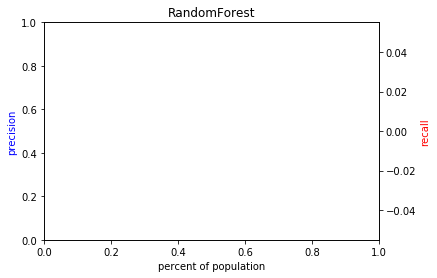

In [126]:
res_df = ml.classifier_loop(temp_lst, GRID, CLFRS_TO_RUN, METRIC_DICT, LABEL, preds_drop,
                            METRICS, plot=True, save=False)

In [99]:
res_df

,model,importances,parameters,set,train_start,train_end,test_start,test_end,precision_at_100,precision_at_5,precision_at_20,precision_at_50,precision_at_80,recall_at_100,recall_at_5,recall_at_20,recall_at_50,recall_at_80,f1_at_5,accuracy_at_50
0,RandomForest,"[0.34201790668043464, 0.25577050400514667, 0.1...","{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0,2010-01-01,2012-12-30 17:27:36,2015-01-02 05:06:00,2016-12-30 16:44:24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500234


**3. Changes in scope**

For our project, we will be creating two outcome variables and testing the effect of network features on both outcomes. The first outcome is whether or not a police officer is involved in the use of a firearm over the next two years. The next outcome is whether or not a police officer has a sustained investigation over the next two years. While our overarching policy goal is to determine whether or not network features have an influence on police officers using unjust force in order to inform journalistic investigation, we do not have a perfect proxy for this outcome, and therefore are using these two outcome variables to better inform the interpretation of our results.